# Using Machine Learning to Predict Countries' Climate Readiness
By Narat Jaitui

## Label Encode the target Variable 
here we encode ND-GAIN Matrix label {"Red":0,"Yellow":1,"Blue":2,"Green":3} for all data point retrieved from ND-GAIN. The source file for the index includes the 2 principal components "readiness.csv" and "vulnerability.csv", which are used to compute the matrix as follows:

In [3]:
import pandas as pd
import numpy as np
import re

# 1) Load Data
R = pd.read_csv("readiness.csv")
V = pd.read_csv("vulnerability.csv")


# 2) Detect year columns and keep only years that exist in BOTH files
years = sorted(
    [y for y in (set([c for c in R.columns if re.fullmatch(r"\d{4}", str(c))]) &
                 set([c for c in V.columns if re.fullmatch(r"\d{4}", str(c))]))
     if int(y) >= 2000],
    key=int
)

# 3) Reshape the panel from wide to long so each row becomes a country-year
#    Result: ISO3, Name, year, readiness (and similarly for vulnerability)
r = R.melt(["ISO3","Name"], years, "year", "readiness")
v = V.melt(["ISO3","Name"], years, "year", "vulnerability")

# 4) Merge into one table: one row per ISO3-year with both readiness + vulnerability
df = (r.merge(v[["ISO3","year","vulnerability"]], on=["ISO3","year"])
        .assign(
            year=lambda d: d.year.astype(int),
            readiness=lambda d: pd.to_numeric(d.readiness, errors="coerce"),
            vulnerability=lambda d: pd.to_numeric(d.vulnerability, errors="coerce")
        ))

# 5) ND-GAIN matrix cutoffs: WORLD MEDIANS each year (median readiness and vulnerability)
med = df.groupby("year")[["readiness","vulnerability"]].median()
df = df.join(med, on="year", rsuffix="_med")   # adds readiness_med, vulnerability_med

# 6) Classify quadrants using ND-GAIN logic (>= median means “high”)
#    Readiness = x-axis, Vulnerability = y-axis
hr = df.readiness >= df.readiness_med           # high readiness
hv = df.vulnerability >= df.vulnerability_med   # high vulnerability

# ND-GAIN quadrant colors:
# Red    = high vulnerability, low readiness  (upper-left)
# Yellow = low  vulnerability, low readiness  (lower-left)
# Blue   = high vulnerability, high readiness (upper-right)
# Green  = low  vulnerability, high readiness (lower-right)
df["matrix_color"] = np.select(
    [hv & ~hr, ~hv & ~hr, hv & hr, ~hv & hr],
    ["Red","Yellow","Blue","Green"]
)

# 7) Encode as requested: Red=0, Yellow=1, Blue=2, Green=3
df["matrix_class"] = df.matrix_color.map({"Red":0,"Yellow":1,"Blue":2,"Green":3}).astype("Int64")

# 8) Save final dataset
df[["ISO3","Name","year","readiness","vulnerability","matrix_color","matrix_class"]]\
  .sort_values(["ISO3","year"])\
  .to_csv("nd_gain_matrix_labeled.csv", index=False)

In [7]:
out = pd.read_csv("nd_gain_matrix_labeled.csv")
out.head(10)

,ISO3,Name,year,readiness,vulnerability,matrix_color,matrix_class
0,AFG,Afghanistan,2000,0.309709,0.608398,Red,0
1,AFG,Afghanistan,2001,0.310498,0.606533,Red,0
2,AFG,Afghanistan,2002,0.311304,0.604601,Red,0
3,AFG,Afghanistan,2003,0.304292,0.593451,Red,0
4,AFG,Afghanistan,2004,0.304013,0.595817,Red,0
5,AFG,Afghanistan,2005,0.244088,0.602124,Red,0
6,AFG,Afghanistan,2006,0.216438,0.604629,Red,0
7,AFG,Afghanistan,2007,0.203330,0.600051,Red,0
8,AFG,Afghanistan,2008,0.196948,0.599393,Red,0
9,AFG,Afghanistan,2009,0.204766,0.599694,Red,0


## Load the Predictors
here we fetch WDI data for each country-year from the World Bank API using wbgapi package

In [29]:
import wbgapi as wb
import pandas as pd

# PART 1: WDI Predictors (Multiple Variables) ---
indicators_wdi = {
    'NV.AGR.TOTL.ZS': 'Ag_Value_Added',
    'SH.H2O.BASW.ZS': 'Water_Access',
    'SH.DYN.MORT':    'Child_Mortality',
    'AG.LND.AGRI.ZS': 'Ag_Land_Percent',
    'SP.URB.TOTL.IN.ZS': 'Urban_Pop',
    'EG.ELC.ACCS.ZS': 'Electricity_Access',
    'IT.CEL.SETS.P2': 'Mobile_Subs',
    'NY.GDP.PCAP.CD': 'GDP_Per_Capita',
    'BX.KLT.DINV.WD.GD.ZS': 'FDI_Inflows',
    'SE.SEC.ENRR':    'School_Enrollment',
    'SL.UEM.TOTL.ZS': 'Unemployment'
}

country_list = sorted(out["ISO3"].dropna().unique().tolist())
print(f"Fetching WDI data...")

# 1. Fetch WDI (Database 2)
df_wdi = wb.data.DataFrame(indicators_wdi.keys(), economy=country_list, time=range(2000, 2023), labels=False, skipAggs=True, db=2)
df_wdi.reset_index(inplace=True)

# FIX: Force lowercase columns to handle 'Series' vs 'series'
df_wdi.columns = [c.lower() for c in df_wdi.columns]

# Melt WDI (Has 'series' column)
df_wdi = df_wdi.melt(id_vars=['economy', 'series'], var_name='year', value_name='value')
df_wdi['year'] = df_wdi['year'].str.replace('yr', '').astype(int)
df_wdi = df_wdi.pivot_table(index=['economy', 'year'], columns='series', values='value').reset_index()
df_wdi.rename(columns=indicators_wdi, inplace=True)

# PART 2: Governance Data
print("Fetching Governance Data...")

# 2. Fetch Governance (Database 3)
df_gov = wb.data.DataFrame(['GE.EST'], economy=country_list, time=range(2000, 2023), labels=False, skipAggs=True, db=3)
df_gov.reset_index(inplace=True)

#Force lowercase columns
df_gov.columns = [c.lower() for c in df_gov.columns]

# Melt without 'series' ( a fix from earlier error because it's missing for single-var requests)
df_gov = df_gov.melt(id_vars=['economy'], var_name='year', value_name='Gov_Effectiveness')
df_gov['year'] = df_gov['year'].str.replace('yr', '').astype(int)

# PART 3: Merge
df_X = pd.merge(df_wdi, df_gov, on=['economy', 'year'], how='left')

print("Success! Final Data Shape:", df_X.shape)
df_X.to_csv("df_X.csv", index=False)


Fetching WDI data...
Fetching Governance Data...
Success! Final Data Shape: (4416, 14)


## Data preprocessing 
here we (1) Merge predictor and target dataframe (2)perform linear Interpolation (3)split the train-test data using stratified split and (4) Normalization for numerical stability

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. MERGE PREDICTORS (X) WITH TARGET (Y) ---
# Load the target file
df_target = pd.read_csv("nd_gain_matrix_labeled.csv")

# Merge on df_X 'economy', and df_target 'ISO3'
# We use 'inner' join to keep only rows where we have both predictors and a label
df_merged = pd.merge(
    df_X, 
    df_target[['ISO3', 'year', 'matrix_class']], 
    left_on=['economy', 'year'],
    right_on=['ISO3', 'year'],
    how='inner'
)

In [33]:
df_merged.head()

,economy,year,Ag_Land_Percent,FDI_Inflows,Electricity_Access,Mobile_Subs,Ag_Value_Added,GDP_Per_Capita,School_Enrollment,Child_Mortality,Water_Access,Unemployment,Urban_Pop,Gov_Effectiveness,ISO3,matrix_class
0,AFG,2000,57.945817,0.004828,4.4,0.000000,NaN,174.930991,NaN,131.7,29.730966,7.935,18.558200,-2.173946,AFG,0
1,AFG,2001,57.947350,0.024169,9.3,0.000000,NaN,138.706822,14.04041,127.4,29.762926,7.953,18.741238,NaN,AFG,0
2,AFG,2002,57.939684,1.306950,14.1,0.116942,38.627892,178.954088,NaN,123.1,31.836077,7.930,18.941248,-1.587687,AFG,0
3,AFG,2003,58.083805,1.278493,19.0,0.879776,37.418855,198.871116,13.95953,118.7,33.908629,7.880,19.160035,-1.175768,AFG,0
4,AFG,2004,58.151266,3.577104,23.8,2.546620,29.721067,221.763654,19.21438,114.2,35.999355,7.899,19.399359,-0.945146,AFG,0


In [38]:
# 2. INTERPOLATE 
# We define our feature columns
numeric_cols = [
    'Ag_Value_Added', 'Water_Access', 'Child_Mortality', 
    'Ag_Land_Percent', 'Urban_Pop', 'Electricity_Access', 
    'Mobile_Subs', 'GDP_Per_Capita', 'FDI_Inflows', 
    'School_Enrollment', 'Unemployment', 'Gov_Effectiveness'
]

# Interpolate missing values strictly within each country's timeline
df_merged[numeric_cols] = df_merged.groupby('economy')[numeric_cols].transform(
    lambda group: group.interpolate(method='linear', limit_direction='both')
)

# Drop any countries that had NO data at all (cannot be interpolated)
df_merged.dropna(subset=numeric_cols, inplace=True)
print(f"Data after interpolation & dropna: {df_merged.shape}")

# 3. STRATIFIED TRAIN-TEST SPLIT 
X = df_merged[numeric_cols]
y = df_merged['matrix_class'] # 0, 1, 2, 3

# Stratify=y ensures the Test set has the same proportion of each class as the train set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=3126
)

print("Split complete.")
print(f"Train size: {X_train.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

# 4. SCALE (NORMALIZE)
scaler = StandardScaler()

# Fit the scaler only on X_train
X_train_scaled = scaler.fit_transform(X_train)

# Transform X_test using the trained scaler
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=numeric_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numeric_cols, index=X_test.index)

print("\nScaling Done")
print(X_train_scaled.head())

Data after interpolation & dropna: (3910, 16)
Split complete.
Train size: 3128
Test size: 782

Scaling Done


,Ag_Value_Added,Water_Access,Child_Mortality,Ag_Land_Percent,Urban_Pop,Electricity_Access,Mobile_Subs,GDP_Per_Capita,FDI_Inflows,School_Enrollment,Unemployment,Gov_Effectiveness
1397,-0.580333,0.110191,0.083323,-1.377359,1.425611,0.242690,0.926609,-0.302057,0.138050,-0.323963,2.118262,-0.990464
2416,-0.651019,0.713999,-0.582389,-0.599644,0.505522,0.690016,-1.039865,-0.483606,-0.144396,0.504519,1.021158,0.401087
225,-0.954728,0.825800,-0.817912,-0.292181,0.509394,0.693305,0.942174,2.050095,-0.493869,0.763786,-0.483171,1.540739
1987,-0.957142,0.754431,-0.820315,-1.136015,1.474374,0.693305,0.251312,1.524909,-0.224145,0.799799,-0.460322,1.534554
49,0.729469,0.169217,-0.351673,0.107600,-0.546204,0.673570,-0.891681,-0.568396,-0.104228,0.004829,1.556678,-0.537507


## Model training and evaluation

In [45]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 2.2 MB/s eta 0:00:00a 0:00:01


In [51]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score

# 1. DEFINE MODELS & PARAMETERS
model_params = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {'C': [0.1, 1, 10]}
    },
    'SVM': {
        'model': SVC(probability=True),
        'params': {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']}
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {'n_estimators': [50, 100], 'max_depth': [5, 10, None]}
    },
    'XGBoost': {
        'model': XGBClassifier(eval_metric='mlogloss'),
        'params': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
    }
}

# 2. RUN TOURNAMENT
comparison_data = []
best_overall_f1 = 0
best_overall_model = None
best_overall_name = ""

print("Starting Model Tournament (5-Fold CV)...")
print("-" * 60)

for name, mp in model_params.items():
    print(f"Training {name}...")
    
    # Grid Search finds the best hyperparameters on Training Set
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, scoring='f1_macro', n_jobs=-1)
    clf.fit(X_train_scaled, y_train)
    
    # Capture the best model from this family
    best_model_in_family = clf.best_estimator_
    
    # Predict on TRAINING Data (To check Overfitting)
    y_train_pred = best_model_in_family.predict(X_train_scaled)
    train_f1 = f1_score(y_train, y_train_pred, average='macro')
    train_acc = accuracy_score(y_train, y_train_pred)
    
    # Predict on TEST Data (To check Generalization)
    y_test_pred = best_model_in_family.predict(X_test_scaled)
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    test_acc = accuracy_score(y_test, y_test_pred)
    
    # Store Stats
    comparison_data.append({
        'Model': name,
        'Best Params': str(clf.best_params_),
        'Train F1': train_f1,
        'Test F1': test_f1,
        'Train Acc': train_acc,
        'Test Acc': test_acc
    })
    
    # Check if this is the new global winner
    if test_f1 > best_overall_f1:
        best_overall_f1 = test_f1
        best_overall_model = best_model_in_family
        best_overall_name = name

# 3. DISPLAY & SAVE RESULTS 
results_df = pd.DataFrame(comparison_data)
results_df = results_df.sort_values(by='Test F1', ascending=False)

print("\n" + "="*30)
print(" FINAL TOURNAMENT STANDINGS")
print("="*30)
# Format columns for readability
print(results_df[['Model', 'Test F1', 'Train F1', 'Test Acc', 'Best Params']].to_markdown(index=False, floatfmt=".4f"))

print(f"\n CHAMPION: {best_overall_name} (F1: {best_overall_f1:.4f})")

# Save to CSV
results_df.to_csv("final_model_results.csv", index=False)
print("Table saved to 'final_model_results.csv'")

Starting Model Tournament (5-Fold CV)...
------------------------------------------------------------
Training Logistic Regression...
Training SVM...
Training Random Forest...
Training XGBoost...

 FINAL TOURNAMENT STANDINGS
| Model               |   Test F1 |   Train F1 |   Test Acc | Best Params                                 |
|:--------------------|----------:|-----------:|-----------:|:--------------------------------------------|
| XGBoost             |    0.9326 |     0.9989 |     0.9540 | {'learning_rate': 0.1, 'n_estimators': 100} |
| Random Forest       |    0.9142 |     1.0000 |     0.9425 | {'max_depth': None, 'n_estimators': 100}    |
| SVM                 |    0.8539 |     0.9038 |     0.9041 | {'C': 10, 'kernel': 'rbf'}                  |
| Logistic Regression |    0.6394 |     0.6599 |     0.7545 | {'C': 10}                                   |

 CHAMPION: XGBoost (F1: 0.9326)
Table saved to 'final_model_results.csv'


## Analysis of the tournament winner

ANALYZING MODEL: XGBoost
------------------------------------------------------------
MOST INFLUENTIAL PREDICTORS (Permutation Importance)
| Feature            |   Importance |   Std Dev |
|:-------------------|-------------:|----------:|
| Gov_Effectiveness  |       0.2419 |    0.0166 |
| Child_Mortality    |       0.1553 |    0.0143 |
| Urban_Pop          |       0.1514 |    0.0087 |
| Electricity_Access |       0.1377 |    0.0097 |
| Ag_Land_Percent    |       0.1114 |    0.0161 |
| Water_Access       |       0.0864 |    0.0096 |
| School_Enrollment  |       0.0737 |    0.0073 |
| Unemployment       |       0.0486 |    0.0077 |
| Ag_Value_Added     |       0.0454 |    0.0103 |
| Mobile_Subs        |       0.0435 |    0.0046 |
| GDP_Per_Capita     |       0.0143 |    0.0065 |
| FDI_Inflows        |       0.0098 |    0.0025 |


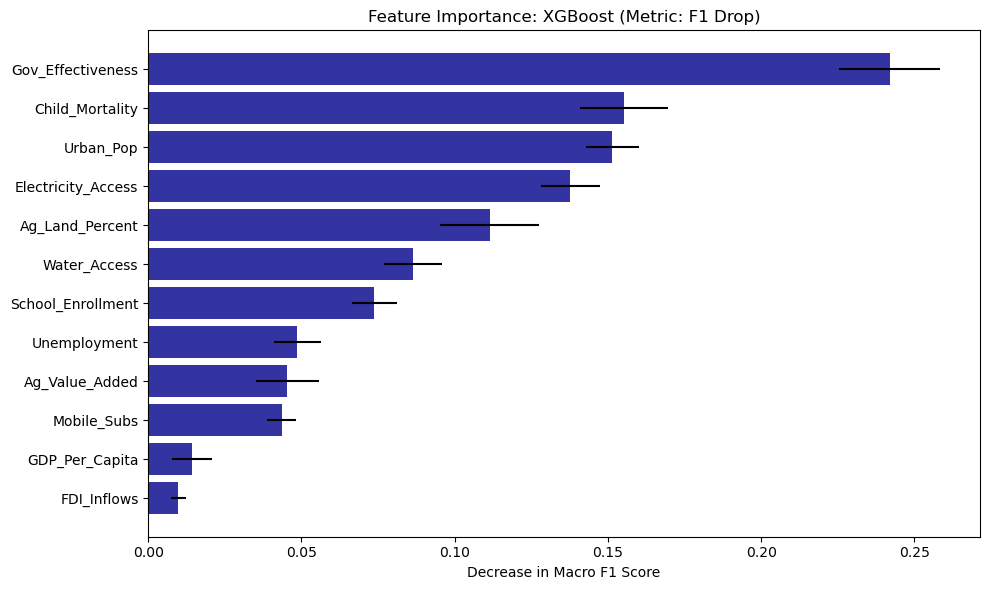


CLASS-WISE CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       289
           1       0.90      0.93      0.92       112
           2       0.94      0.82      0.87        72
           3       0.97      0.97      0.97       309

    accuracy                           0.95       782
   macro avg       0.94      0.92      0.93       782
weighted avg       0.95      0.95      0.95       782



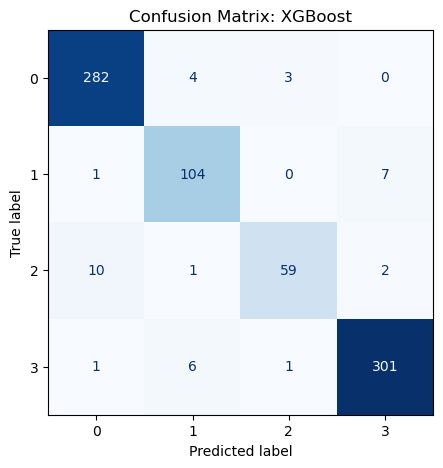

In [69]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Kept for styling, though we use plt.barh

# --- 1. Permutation Importance (Predictor Influence) ---
print(f"ANALYZING MODEL: {best_overall_name}")
print("-" * 60)

# Calculate importance (Metric: Drop in Macro-F1)
perm_result = permutation_importance(
    best_overall_model, X_test_scaled, y_test, 
    n_repeats=10, random_state=42, scoring='f1_macro'
)

# Organize results
df_imp = pd.DataFrame({
    'Feature': numeric_cols,
    'Importance': perm_result.importances_mean,
    'Std Dev': perm_result.importances_std
}).sort_values(by='Importance', ascending=True) 

print("MOST INFLUENTIAL PREDICTORS (Permutation Importance)")
# Print descending for readability in the table
print(df_imp.sort_values(by='Importance', ascending=False).to_markdown(index=False, floatfmt=".4f"))

# Plot Predictor Importance using Matplotlib directly
plt.figure(figsize=(10, 6))
plt.barh(df_imp['Feature'], df_imp['Importance'], xerr=df_imp['Std Dev'], color='darkblue', alpha=0.8)
plt.title(f'Feature Importance: {best_overall_name} (Metric: F1 Drop)')
plt.xlabel('Decrease in Macro F1 Score')
plt.tight_layout()
plt.show()

# --- 2. Class-Wise Performance & Confusion Matrix ---
y_pred = best_overall_model.predict(X_test_scaled)

print("\nCLASS-WISE CLASSIFICATION REPORT")
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=best_overall_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_overall_model.classes_)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(cmap='Blues', ax=ax, values_format='d', colorbar=False)
plt.title(f'Confusion Matrix: {best_overall_name}')
plt.show()

## Robustness Check 

In [78]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score

print("ROBUSTNESS CHECK WITH TEMPORAL SPLIT")

# 1. SPLIT TRAIN-TEST
# Train: 2000-2018 (19 years), Test:  2019-2023 (5 years, approx 20% of data)
# Slice the original interpolated merged dataframe (df_merged)
train_temporal = df_merged[df_merged['year'] <= 2018].copy()
test_temporal = df_merged[df_merged['year'] > 2018].copy()

print(f"Training Range: 2000-2018 ({len(train_temporal)} obs)")
print(f"Testing Range:  2019-2023 ({len(test_temporal)} obs)")

# 2. PREPARE FEATURES & TARGETS
X_train_time = train_temporal[numeric_cols]
y_train_time = train_temporal['matrix_class']

X_test_time = test_temporal[numeric_cols]
y_test_time = test_temporal['matrix_class']

# 3. SCALE 
scaler_time = StandardScaler()
X_train_time_scaled = scaler_time.fit_transform(X_train_time)
X_test_time_scaled = scaler_time.transform(X_test_time)

# 4. TRAIN THE CHAMPION MODEL
model_robust = clone(best_overall_model)
model_robust.fit(X_train_time_scaled, y_train_time)

# 5. PREDICT & EVALUATE
y_pred_time = model_robust.predict(X_test_time_scaled)
time_f1 = f1_score(y_test_time, y_pred_time, average='macro')

#  Report
print("\n--- RESULTS: PREDICTING THE FUTURE (2019-2023) ---")
print(f"Temporal Split Macro F1: {time_f1:.4f}")
print(f"(Compare this to your Random Split F1 of {best_overall_f1:.4f})\n")

print("Classification Report (Future Data):")
print(classification_report(y_test_time, y_pred_time))

# Comparison
drop = best_overall_f1 - time_f1
if drop < 0.05:
    print(f" PASSED: Model is robust. Performance drop is negligible ({drop:.4f}).")
elif drop < 0.10:
    print(f" WARNING: Moderate performance drop ({drop:.4f}).")
else:
    print(f" FAILED: Significant drop ({drop:.4f}).")

ROBUSTNESS CHECK WITH TEMPORAL SPLIT
Training Range: 2000-2018 (3230 obs)
Testing Range:  2019-2023 (680 obs)

--- RESULTS: PREDICTING THE FUTURE (2019-2023) ---
Temporal Split Macro F1: 0.8622
(Compare this to your Random Split F1 of 0.9326)

Classification Report (Future Data):
              precision    recall  f1-score   support

           0       0.99      0.89      0.94       255
           1       0.74      0.90      0.81        96
           2       0.83      0.70      0.76        57
           3       0.91      0.96      0.94       272

    accuracy                           0.90       680
   macro avg       0.87      0.86      0.86       680
weighted avg       0.91      0.90      0.91       680

